In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics

from hyperopt import hp, fmin, tpe, Trials, space_eval

import optuna

## Data load

In [2]:
bioResponseData = pd.read_csv('./data/_train_sem09 (1).csv')

bioResponseData.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Data research

Activity
1    0.542255
0    0.457745
Name: proportion, dtype: float64


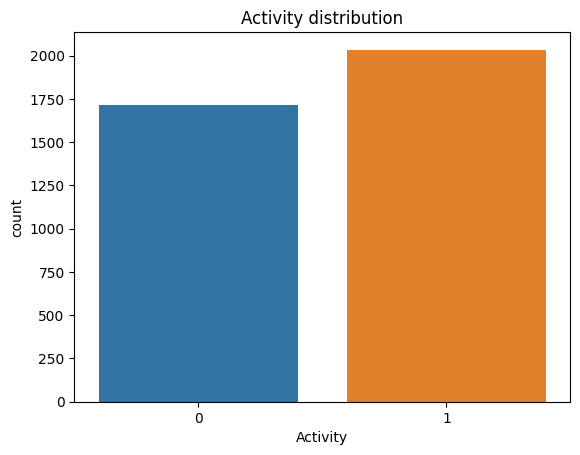

In [3]:
sns.countplot(
    data=bioResponseData,
    x='Activity'
).set(title='Activity distribution')

print(bioResponseData['Activity'].value_counts(normalize=True))

## Data preparation

In [4]:
# Fix seed
random_state = 29

# Select the target variable
X = bioResponseData.drop('Activity', axis=1)
y = bioResponseData['Activity']

# Split
X_train, X_test, y_train, y_test =model_selection.train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=random_state
)

## Modeling

### Default params

In [5]:
# LogisticRegression
lr_default = linear_model.LogisticRegression(random_state=random_state)

lr_default.fit(X_train, y_train)

# RandomForestClassifier
rf_default = ensemble.RandomForestClassifier(random_state=random_state)

rf_default.fit(X_train, y_train)

# Metrics
print('F1-score, LogisticRegression trained on default parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, lr_default.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, lr_default.predict(X_test)).round(2))

print()

print('F1-score, RandomForestClassifier trained on default parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, rf_default.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, rf_default.predict(X_test)).round(2))

c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1-score, LogisticRegression trained on default parameters:
Train sample: 0.89
Test sample: 0.79

F1-score, RandomForestClassifier trained on default parameters:
Train sample: 1.0
Test sample: 0.82


### GridSearchCV

In [6]:
# LogisticRegression

# Grid of params
param_grid_lr = {
    'solver': ['saga', 'lbfgs'],
    'penalty': ['l2', 'none'],
    'C': range(1, 10, 3),
    'max_iter': [500, 1000]
}

# Cross-validator
skf = model_selection.StratifiedKFold()

# Model
lr_gSearch = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state),
    param_grid=param_grid_lr,
    cv=skf,
    n_jobs=-1
)

# Training
lr_gSearch.fit(X_train, y_train)

print('GridSearchCV best params on LogisticRegression:', lr_gSearch.best_params_)
print('F1-score, LogisticRegression trained on best GridSearchCV parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, lr_gSearch.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, lr_gSearch.predict(X_test)).round(2))

GridSearchCV best params on LogisticRegression: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
F1-score, LogisticRegression trained on best GridSearchCV parameters:
Train sample: 0.89
Test sample: 0.79


c:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [7]:
# RandomForestClassifier

# Grid of params
param_grid_rf = {
    'n_estimators': range(100, 201, 30),
    'min_samples_leaf': [5, 7, 9],
    'max_depth': range(5, 26, 5)
}

# Model
rf_gSearch = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid_rf,
    cv=skf,
    n_jobs=-1
)

# Training
rf_gSearch.fit(X_train, y_train)

print('GridSearchCV best params on RandomForestClassifier:', rf_gSearch.best_params_)
print('F1-score, RandomForestClassifier trained best GridSearchCV parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, rf_gSearch.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, rf_gSearch.predict(X_test)).round(2))

GridSearchCV best params on RandomForestClassifier: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
F1-score, RandomForestClassifier trained best GridSearchCV parameters:
Train sample: 0.94
Test sample: 0.81


### RandomizedSearchCV

In [8]:
# LogisticRegression

# Model
lr_rSearch = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state),
    param_distributions=param_grid_lr,
    cv=skf,
    n_iter=10,
    n_jobs=-1,
    random_state=random_state
)

#Training
lr_rSearch.fit(X_train, y_train)

print('RandomizedSearchCV best params on LogisticRegression:', lr_rSearch.best_params_)
print('F1-score, LogisticRegression trained on best RandomizedSearchCV parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, lr_rSearch.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, lr_rSearch.predict(X_test)).round(2))

RandomizedSearchCV best params on LogisticRegression: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 1}
F1-score, LogisticRegression trained on best RandomizedSearchCV parameters:
Train sample: 0.89
Test sample: 0.79


In [9]:
# RandomForestClassifier

# Model
rf_rSearch = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_grid_rf,
    cv=skf,
    n_iter=10,
    n_jobs=-1,
    random_state=random_state
)

# Training
rf_rSearch.fit(X_train, y_train)

# Prediction
y_pred_rf_rSearch = rf_rSearch.predict(X_test)

print('RandomizedSearchCV best params on RandomForestClassifier:', rf_rSearch.best_params_)
print('F1-score, RandomForestClassifier trained best RandomizedSearchCV parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, rf_rSearch.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, rf_rSearch.predict(X_test)).round(2))

RandomizedSearchCV best params on RandomForestClassifier: {'n_estimators': 160, 'min_samples_leaf': 5, 'max_depth': 20}
F1-score, RandomForestClassifier trained best RandomizedSearchCV parameters:
Train sample: 0.94
Test sample: 0.81


### Hyperopt

In [10]:
# LogisticRegression

# Space of params
space_lr = {
    'solver': hp.choice('solver', ['lbfgs', 'saga', 'newton-cg']),
    'max_iter': hp.choice('max_iter', [500, 700, 1000]),
    'penalty': hp.choice('penalty', ['l2', 'none']),
    'C' : hp.uniform('C', 0.05, 3)
}
   

def hyperopt_lr(params: dict, cv: sklearn.model_selection.BaseCrossValidator=skf,
                X: np.ndarray | pd.DataFrame=X_train, y: np.ndarray | pd.DataFrame=y_train,
                random_state: int=random_state) -> float:
    """Function fit LogisticRegression with set params
    and return -f1-score on cross-validation

    Args:
        params (dict): Hyperparameters.
        cv (sklearn.model_selection.BaseCrossValidator, optional): Cross-validator. Defaults to StratifiedKFold.
        X (np.ndarray | pd.DataFrame, optional): Train data. Defaults to X_train.
        y (np.ndarray | pd.DataFrame, optional): Train target. Defaults to y_train.
        random_state (int, optional): Seed. Defaults to random_state.

    Returns:
        float: -f1-score
    """
    
    # Preparing model
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    
    # Get f1-score using cross-validation
    score = model_selection.cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    ).mean()
    
    return -score


# Tuning

trials = Trials()

# Best params
best = fmin(
    fn=hyperopt_lr,
    space=space_lr,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10,
    rstate=np.random.default_rng(random_state)
)

# Fitting model on best params
lr_hyperopt = linear_model.LogisticRegression(**space_eval(space_lr, best), random_state=random_state)

lr_hyperopt.fit(X_train, y_train)

print('Hyperopt best params on LogisticRegression:', space_eval(space_lr, best))
print('F1-score, LogisticRegression trained on best Hyperopt parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, lr_hyperopt.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, lr_hyperopt.predict(X_test)).round(2))

100%|██████████| 10/10 [05:21<00:00, 32.17s/trial, best loss: -0.7787167707858366]
Hyperopt best params on LogisticRegression: {'C': 0.2850236437426646, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
F1-score, LogisticRegression trained on best Hyperopt parameters:
Train sample: 0.87
Test sample: 0.8


In [11]:
# RandomForestClassifier

# Space of params
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
    'max_depth': hp.quniform('max_depth', 5, 21, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 10, 1)
}

def hyperopt_rf(params: dict, cv: sklearn.model_selection.BaseCrossValidator=skf,
                X: np.ndarray | pd.DataFrame=X_train, y: np.ndarray | pd.DataFrame=y_train,
                random_state: int=random_state) -> float:
    """Function fit RandomForestClassifier with set params
    and return -f1-score on cross-validation

    Args:
        params (dict): Hyperparameters.
        cv (sklearn.model_selection.BaseCrossValidator, optional): Cross-validator. Defaults to StratifiedKFold.
        X (np.ndarray | pd.DataFrame, optional): Train data. Defaults to X_train.
        y (np.ndarray | pd.DataFrame, optional): Train target. Defaults to y_train.
        random_state (int, optional): Seed. Defaults to random_state.

    Returns:
        float: -f1-score
    """
    params = {param: int(params[param]) for param in params}
    
    # Preparing model
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # Get f1-score using cross-validation
    score = model_selection.cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    ).mean()
    
    return -score

# Tuning

trials = Trials()

# Best params
best = fmin(
    fn=hyperopt_rf,
    space=space_rf,
    algo=tpe.suggest,
    trials=trials,
    max_evals=20,
    rstate=np.random.default_rng(random_state)
)

# Type conversion
params = space_eval(space_rf, best)
best = {param: int(params[param]) for param in params}

# Fitting model on best params
rf_hyperopt = ensemble.RandomForestClassifier(**best, random_state=random_state)

rf_hyperopt.fit(X_train, y_train)

print('Hyperopt best params on RandomForestClassifier:', best)
print('F1-score, RandomForestClassifier trained on best Hyperopt parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, rf_hyperopt.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, rf_hyperopt.predict(X_test)).round(2))

100%|██████████| 20/20 [01:01<00:00,  3.09s/trial, best loss: -0.8015434037400835]
Hyperopt best params on RandomForestClassifier: {'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 240}
F1-score, RandomForestClassifier trained on best Hyperopt parameters:
Train sample: 0.91
Test sample: 0.81


### Optuna

In [13]:
# LogisticRegression

def optuna_lr(trial: optuna.trial.Trial) -> float:
    """Function fit LogisticRegression with set params
    and return f1-score on cross-validation

    Args:
        trial (optuna.trial.Trial): A trial is a process of evaluating an objective function

    Returns:
        float: f1-score
    """
    # Params
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs', 'newton-cg'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    C = trial.suggest_float('C', 0.1 , 3, step=0.1)
    
    model = linear_model.LogisticRegression(
        solver=solver,
        max_iter=max_iter,
        penalty=penalty,
        C=C,
        random_state=random_state
    )
    
    score = model_selection.cross_val_score(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )
    
    return score.mean()


# Tuning
study_lr = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study_lr.optimize(optuna_lr, n_trials=10, n_jobs=-1)

# Modeling
lr_optuna = linear_model.LogisticRegression(**study_lr.best_params, random_state=random_state)

lr_optuna.fit(X_train, y_train)

print('Optuna best params on LogisticRegression:', study_lr.best_params)
print('F1-score, LogisticRegression trained on best Optuna parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, lr_optuna.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, lr_optuna.predict(X_test)).round(2))

[I 2023-07-23 19:42:52,123] A new study created in memory with name: LogisticRegression
[I 2023-07-23 19:43:55,294] Trial 1 finished with value: 0.7471393601241558 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 100, 'C': 1.7000000000000002}. Best is trial 1 with value: 0.7471393601241558.
[I 2023-07-23 19:43:59,534] Trial 2 finished with value: 0.7103939503905878 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 800, 'C': 1.7000000000000002}. Best is trial 1 with value: 0.7471393601241558.
[I 2023-07-23 19:44:18,870] Trial 3 finished with value: 0.773964231588044 and parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 700, 'C': 0.7000000000000001}. Best is trial 3 with value: 0.773964231588044.
[I 2023-07-23 19:44:34,191] Trial 0 finished with value: 0.7704332663602563 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'C': 1.2000000000000002}. Best is trial 3 with value: 0.773964231588044.
[I 2023-07-23 19:44:34,797] Tria

Optuna best params on LogisticRegression: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'C': 0.7000000000000001}
F1-score, LogisticRegression trained on best Optuna parameters:
Train sample: 0.88
Test sample: 0.8


c:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# Visualization
optuna.visualization.plot_param_importances(study_lr, target_name='f1_score') \
    .update_layout(title='Hyperparameters importances for LogisticRegression')

In [15]:
# RandomForestClassifier
def optuna_rf(trial: optuna.trial.Trial) -> float:
    """Function fit RandomForestClassifier with set params
    and return f1-score on cross-validation

    Args:
        trial (optuna.trial.Trial): A trial is a process of evaluating an objective function

    Returns:
        float: f1-score
    """
    # Params
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=10)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    score = model_selection.cross_val_score(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )
    
    return score.mean()


# Tuning
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(optuna_rf, n_trials=20, n_jobs=-1)

# Modeling
rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params, random_state=random_state)

rf_optuna.fit(X_train, y_train)

print('Optuna best params on RandomForestClassifier:', study_rf.best_params)
print('F1-score, RandomForestClassifier trained on best Optuna parameters:')
print('Train sample:', \
    metrics.f1_score(y_train, rf_optuna.predict(X_train)).round(2))
print('Test sample:', \
    metrics.f1_score(y_test, rf_optuna.predict(X_test)).round(2))

[I 2023-07-23 19:50:16,112] A new study created in memory with name: RandomForestClassifier
[I 2023-07-23 19:50:37,556] Trial 0 finished with value: 0.8026043841809679 and parameters: {'n_estimators': 110, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8026043841809679.
[I 2023-07-23 19:50:39,701] Trial 1 finished with value: 0.7588044656162667 and parameters: {'n_estimators': 290, 'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8026043841809679.
[I 2023-07-23 19:50:41,140] Trial 6 finished with value: 0.808664043557938 and parameters: {'n_estimators': 110, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.808664043557938.
[I 2023-07-23 19:50:41,152] Trial 7 finished with value: 0.7545861880999781 and parameters: {'n_estimators': 180, 'max_depth': 5, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.808664043557938.
[I 2023-07-23 19:50:41,714] Trial 3 finished with value: 0.7982282551222528 and parameters: {'n_esti

Optuna best params on RandomForestClassifier: {'n_estimators': 250, 'max_depth': 15, 'min_samples_leaf': 3}
F1-score, RandomForestClassifier trained on best Optuna parameters:
Train sample: 0.96
Test sample: 0.82


In [23]:
# Visualization
optuna.visualization.plot_param_importances(study_rf, target_name='f1_score') \
    .update_layout(title='Hyperparameters importances for RandomForestClassifier')

### **Conclusion:** there are various ways to select hyperparameters of models, and of the four options considered, the Optuna library turned out to be the fastest and most convenient tool, which also provides a built-in visualization of various characteristics (the paper presents graphs of the importance of hyperparameters for building a model). RandomizedSearchCV and Hyperopt also work quite fast, while the first option considers random combinations of hyperparameter groups without taking into account previous results, so this method is less preferable, as is GridSearchCV (which is the most resource-intensive and time-consuming).